### Project Title:

Classification of depression patients w/o and with oversampling technique.

### Author: Luca D'Alessandro

### Objective:

This project is focused on some practices of data curation, an important step to correctly feed data to ML models.\
Random Forest Classifier is optimized and fitted on unbalanced or balanced data. \
Moreover, feature selection and feature insight methods are implemented.

### Conclusions:

Data were properly curated accordingly to them being continuous, binary or categorical. NAs were also properly managed. \
The capability of RF models to handle unbalanced data make unuseful the use of oversampling technique (SMOTE) in this case. \
Partial Dependence Plot gives insights on the interaction between variables in predicting the outcome.\
Age is strongly related to depression status, along with Work Pressure.

# Download and extract data

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c playground-series-s4e11

In [ ]:
!unzip playground-series-s4e11.zip

# Import modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix

# Get data

In [ ]:
data = pd.read_csv("train.csv") # these data will be split into train and test datasets

In [ ]:
data.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [ ]:
len(data)

140700

In [ ]:
X = data.drop("Depression", axis = 1)
y = data["Depression"]

# Data cleaning

In [ ]:
# Chech the amount of NAs in each feature

NA_counts = pd.DataFrame({"N. NAs":X.isna().sum(), "%Nas":X.isna().sum()/len(data)})
NA_counts

,N. NAs,%Nas
id,0,0.000000
Name,0,0.000000
Gender,0,0.000000
Age,0,0.000000
City,0,0.000000
Working Professional or Student,0,0.000000
Profession,36630,0.260341
Academic Pressure,112803,0.801727
Work Pressure,27918,0.198422
CGPA,112802,0.801720


In [ ]:
# We get rid of variables with more than 80% NAs

features_to_drop = NA_counts[NA_counts["%Nas"]>=0.8].index.tolist()
X = X.drop(features_to_drop, axis=1)
X.columns

Index(['id', 'Name', 'Gender', 'Age', 'City',
       'Working Professional or Student', 'Profession', 'Work Pressure',
       'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness'],
      dtype='object')

In [ ]:
# For the features with around 20% NAs, we treat them replacing NAs with meaningful values,
# like "Not Specified" for string not ordinal categorical variables,
# and -1 for numerical ordinal categorical variables

ordinal_cat_features = ["Work Pressure", "Job Satisfaction", "Work/Study Hours", "Financial Stress"]
sleep_duration = ["Sleep Duration"] # I put this aside because it is ordinal but in string form
not_ordinal_cat_features = ["Profession", "Degree"]

In [ ]:
# Let's manage the "Sleep Duration" variable

X[sleep_duration].value_counts()

,count
Sleep Duration,
Less than 5 hours,38784
7-8 hours,36969
More than 8 hours,32726
5-6 hours,32142
3-4 hours,12
6-7 hours,8
4-5 hours,7
4-6 hours,5
2-3 hours,5


In [ ]:
# Let's consider only the top 4 represented categories

X["Sleep Duration"] = X["Sleep Duration"].map({"Less than 5 hours":0, "5-6 hours":1, "7-8 hours":2, "More than 8 hours":3})

In [ ]:
X["Sleep Duration"].value_counts()

,count
Sleep Duration,
0.0,38784
2.0,36969
3.0,32726
1.0,32142


In [ ]:
# Let's manage ordinal categorical features
# First we check if they are all numerical

for f in ordinal_cat_features:
  print(X[f].dtype)

float64
float64
float64
float64


In [ ]:
# Now we replace NA values with -1

for f in ordinal_cat_features:
  X[f] = X[f].fillna(-1)

In [ ]:
# Let's verify that NAs disappeared

X[ordinal_cat_features].isna().sum()

,0
Work Pressure,0
Job Satisfaction,0
Work/Study Hours,0
Financial Stress,0


In [ ]:
# Now let's manage not ordinal features
# First, let's verify their type

for f in not_ordinal_cat_features:
  print(X[f].dtype)

object
object


In [ ]:
# Now let's replace NA values with "not specified"

for f in not_ordinal_cat_features:
  X[f] = X[f].fillna("not specified")

In [ ]:
X[not_ordinal_cat_features].isna().sum()

,0
Profession,0
Degree,0


In [ ]:
# Let's convert not ordinal categorical features to one-hot encoding

onehot = X[not_ordinal_cat_features]
onehot = pd.get_dummies(onehot.astype("category"))
onehot = onehot.astype(int)

In [ ]:
# Now, let's individuate binary features and convert their values to 0 and 1

num_values = []
for c in X.columns:
  num_values.append(len(X[c].dropna().value_counts()))
num_values = np.array(num_values)

In [ ]:
binary_feats = X.columns[np.where(num_values==2)[0]]

In [ ]:
for bf in binary_feats:
  feature = X[bf]
  bf_value_0 = np.unique(feature.values)[0]
  bf_value_1 = np.unique(feature.values)[1]
  binarized_feature = feature.map({bf_value_0:0 , bf_value_1:1}).values
  X[bf] = binarized_feature

In [ ]:
# Put all together

X_data = pd.concat([X[binary_feats], onehot, X[ordinal_cat_features], X["Age"]],axis=1)

In [ ]:
# Check NAs

np.unique(X_data.isna().sum())

array([0])

In [ ]:
y.value_counts()

,count
Depression,
0,115133
1,25567


In [ ]:
# As we can see, the model is unbalanced for the target variable

# Split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y, random_state=123)

In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())

Depression
0    86328
1    19197
Name: count, dtype: int64
Depression
0    28805
1     6370
Name: count, dtype: int64


# Univariate feature selection using Mutual Information

In [ ]:
mic = mutual_info_classif(X_train, y_train)

In [ ]:
mic_res = pd.DataFrame(mic, index = X_train.columns, columns = ["MIC"])
mic_res.sort_values("MIC",ascending=False).head(10)

,MIC
Age,0.201848
Work Pressure,0.138215
Profession_not specified,0.134335
Working Professional or Student,0.130601
Job Satisfaction,0.128038
Have you ever had suicidal thoughts ?,0.076385
Degree_Class 12,0.033754
Financial Stress,0.028661
Work/Study Hours,0.024701
Profession_Teacher,0.016816


In [ ]:
# Select a score threshold to select important variables

mic_thresh = 0.03
selected_features = mic_res[mic_res["MIC"]>mic_thresh].index

In [ ]:
# Reduce the original training set by retaining the selected variables

X_train_reduced = X_train[selected_features]

# Model training and selection

In [ ]:
# We will test the following models
# Model trained on the selected categorical variables
# Model trained on the selected categorical variables, with oversampling by SMOTE

In [ ]:
# First, we instantiate a RF classifier and tune hyperparameters with a
# GridSearchCV, fitted on the data with selected categorical variables,
# without oversampling.
# We use balanced accuracy as metric.


param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier()
grid_search = RandomizedSearchCV(rf, param_grid, cv=5, scoring="balanced_accuracy")
grid_search.fit(X_train_reduced, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True],
                                        'class_weight': [None, 'balanced'],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 500]},
                   scoring='balanced_accuracy')

In [ ]:
# Let's check the best parameters found

grid_search.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 10,
 'class_weight': 'balanced',
 'bootstrap': True}

In [ ]:
print(f"CV best score: {grid_search.best_score_:.4f}")

CV best score: 0.8979


In [ ]:
# Let's check the OOB score of the best model fitted on train data

rf = RandomForestClassifier(oob_score=True, random_state=42, **grid_search.best_params_)
rf.fit(X_train_reduced, y_train)
print(f"OOB score = {rf.oob_score_:.4f}")

OOB score = 0.8850


In [ ]:
# Let's now oversample the previous dataset with SMOTE...

In [ ]:
smote = SMOTE(random_state=42)
X_train_reduced_resampled, y_train_resampled = smote.fit_resample(X_train_reduced, y_train)

In [ ]:
# ... and check CV accuracy scores

In [ ]:
rf1 = RandomForestClassifier(oob_score=True, random_state=43, **grid_search.best_params_)
rf1.fit(X_train_reduced_resampled, y_train_resampled)

scores_res = cross_val_score(rf1, X_train_reduced_resampled, y_train_resampled,scoring="accuracy") # not balanced_accuracy
                                                                                                  # since we balanced data through SMOTE
mean_score_res = np.mean(scores_res)

In [ ]:
print(f"Mean CV score: {mean_score_res:.4f}")
print(f"OOB score: {rf1.oob_score_:.4f}")

Mean CV score: 0.9041
OOB score: 0.9045


In [ ]:
y_pred = rf.predict(X_test[X_train_reduced.columns])
y_pred_res = rf1.predict(X_test[X_train_reduced.columns])

print("RF w/o oversampling - Metrics")
print(f"BA score: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"Confusion matrix: {confusion_matrix(y_test, y_pred)}")
print("\n")
print("RF with oversampling - Metrics")
print(f"BA score: {balanced_accuracy_score(y_test, y_pred_res):.4f}")
print(f"Confusion matrix: {confusion_matrix(y_test, y_pred_res)}")

RF w/o oversampling - Metrics
BA score: 0.8942
Confusion matrix: [[25180  3625]
 [  546  5824]]


RF with oversampling - Metrics
BA score: 0.8926
Confusion matrix: [[25347  3458]
 [  604  5766]]


In [ ]:
feature_importance = pd.DataFrame({"Feature":X_train_reduced.columns, "Importance":rf.feature_importances_, "Index":range(0,len(X_train_reduced.columns))})
feature_importance.sort_values("Importance",ascending=False).head(10)

,Feature,Importance,Index
6,Age,0.449691,6
2,Profession_not specified,0.149762,2
4,Work Pressure,0.125236,4
1,Have you ever had suicidal thoughts ?,0.120282,1
5,Job Satisfaction,0.091223,5
0,Working Professional or Student,0.051254,0
3,Degree_Class 12,0.012551,3


<ipython-input-90-ed7010968e55>:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


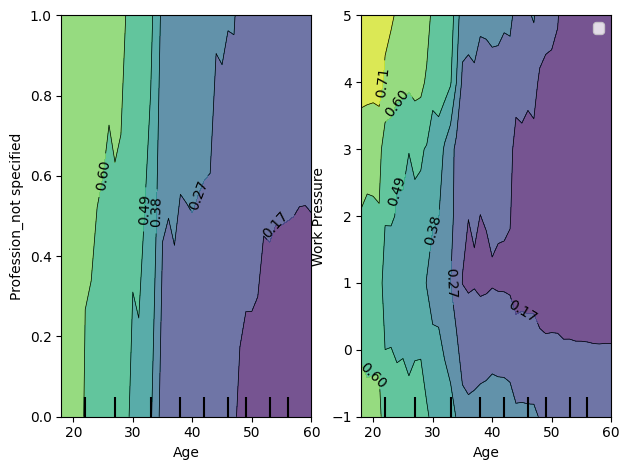

In [ ]:
# Plot marginal dependencies

PartialDependenceDisplay.from_estimator(
    rf,
    X_train_reduced,
    features=[(6,2),(6,4)],
    target=1,
    kind='average',
)


plt.tight_layout()
plt.legend()

<ipython-input-96-45be306a7ada>:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


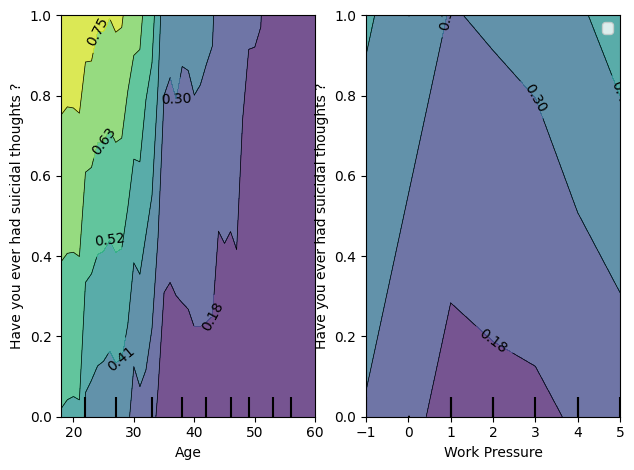

In [ ]:
PartialDependenceDisplay.from_estimator(
    rf,
    X_test[X_train_reduced.columns],
    features=[(6,1),(4,1)],
    target=1,
    kind='average',
)


plt.tight_layout()
plt.legend()

In [ ]:
feature_importance_res = pd.DataFrame({"Feature":X_train_reduced_resampled.columns, "Importance":rf1.feature_importances_, "Index":range(0,len(X_train_reduced_resampled.columns))})
feature_importance_res.sort_values("Importance",ascending=False).head(10)

,Feature,Importance,Index
6,Age,0.410424,6
2,Profession_not specified,0.171772,2
4,Work Pressure,0.127677,4
1,Have you ever had suicidal thoughts ?,0.124007,1
5,Job Satisfaction,0.078780,5
0,Working Professional or Student,0.074249,0
3,Degree_Class 12,0.013089,3


<ipython-input-95-f8475c673785>:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


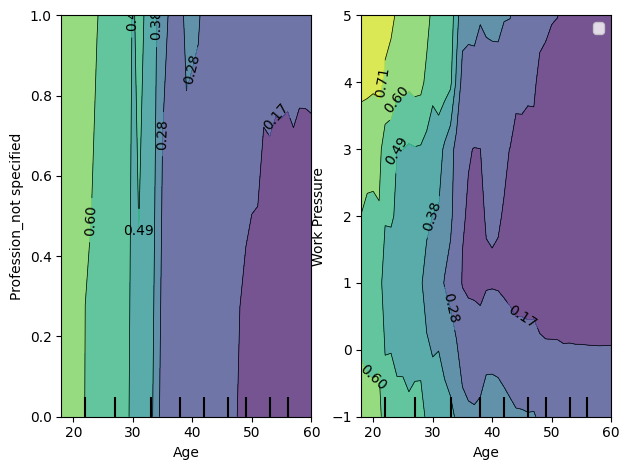

In [ ]:
PartialDependenceDisplay.from_estimator(
    rf1,
    X_test[X_train_reduced.columns],
    features=[(6,2),(6,4)],
    target=1,
    kind='average',
)


plt.tight_layout()
plt.legend()